# 2 Layer Neural Network Regression

In this project created by Yida Wang, 2 layer neural network is used for predicting funds index with the help of SGD training of multiple csv files. It's simple and clean enough for CPU based equipment.

In [3]:
"""
Copyright (c) 2017, Yida Wang
All rights reserved.

Use of this source code is governed by a BSD-style license that can be found
in the LICENSE file.
"""

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Define functions for file scanning 

In [4]:
class ScanFile(object):
    def __init__(self,directory,prefix=None,postfix='.csv'):
        self.directory=directory
        self.prefix=prefix
        self.postfix=postfix

    def scan_files(self):
        files_list=[]

        for dirpath,dirnames,filenames in os.walk(self.directory):
            '''''
            dirpath is a string, the path to the directory.
            dirnames is a list of the names of the subdirectories in dirpath (excluding '.' and '..').
            filenames is a list of the names of the non-directory files in dirpath.
            '''
            for special_file in filenames:
                if self.postfix:
                    special_file.endswith(self.postfix)
                    files_list.append(os.path.join(dirpath,special_file))
                elif self.prefix:
                    special_file.startswith(self.prefix)
                    files_list.append(os.path.join(dirpath,special_file))
                else:
                    files_list.append(os.path.join(dirpath,special_file))

        return files_list

    def scan_subdir(self):
        subdir_list=[]
        for dirpath,dirnames,files in os.walk(self.directory):
            subdir_list.append(dirpath)
        return subdir_list

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, I write the code to load and prepare the data.

In [5]:
# Here is where we get the raw data

files_dir = '/Volumes/MachineFunds/data_3000'
file_scanner=ScanFile(files_dir)
data_list=file_scanner.scan_files()

# Here we set 'header' equals to None to indicate that there are no headers in the csv
# file, Here the index is int64 rather than string.
for idx, data_path in enumerate(data_list):
    if idx == 0:
        raw_data = pd.read_csv(data_path, delimiter=',', header=None)
        print('Here we start to load all the data as listed below:')
        print('File %d:' %(idx+1), data_path)
    else:
        raw_data_temp = pd.read_csv(data_path, delimiter=',', header=None)
        raw_data = raw_data.append(raw_data_temp)
        print('File %d:' %(idx+1), data_path)

# Get the target labels in the second column and use remaining columns as feature
targets = raw_data[1]

# the first column is really large which doesn't mean anything and the first second
# column is all the same which makes it impossible to get scaled
features = raw_data.drop([0, 1], axis=1)

# delete the raw data
del raw_data

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Here we start to load all the data as listed below:
File 1: /Volumes/MachineFunds/data_3000/1.csv
File 2: /Volumes/MachineFunds/data_3000/10.csv
File 3: /Volumes/MachineFunds/data_3000/11.csv
File 4: /Volumes/MachineFunds/data_3000/12.csv
File 5: /Volumes/MachineFunds/data_3000/13.csv
File 6: /Volumes/MachineFunds/data_3000/14.csv
File 7: /Volumes/MachineFunds/data_3000/15.csv
File 8: /Volumes/MachineFunds/data_3000/16.csv
File 9: /Volumes/MachineFunds/data_3000/17.csv
File 10: /Volumes/MachineFunds/data_3000/18.csv
File 11: /Volumes/MachineFunds/data_3000/19.csv
File 12: /Volumes/MachineFunds/data_3000/2.csv
File 13: /Volumes/MachineFunds/data_3000/20.csv
File 14: /Volumes/MachineFunds/data_3000/21.csv
File 15: /Volumes/MachineFunds/data_3000/22.csv
File 16: /Volumes/MachineFunds/data_3000/23.csv
File 17: /Volumes/MachineFunds/data_3000/24.csv
File 18: /Volumes/MachineFunds/data_3000/25.csv
File 19: /Volumes/MachineFunds/data_3000/26.csv
File 20: /Volumes/MachineFunds/data_3000/27.csv

# Wash the raw data
Here we find some data in columns in form is not a number and delete those columns to further our experiments.

In [6]:
# trace of the features
trace = np.linalg.matrix_rank(features.values)

# here is what we do to remove those columns with not a number values, column indexes
# are printed.
nan_col = np.where(np.isnan(features.values) == True)[1]
print('Not a Number is located there: ', nan_col)

# we drop those useless columns
features = features.dropna(axis=1)

/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1591: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)


Not a Number is located there:  [2726 2727 2333 ..., 2771 2772 2773]


In [7]:
# Head of the features
print(np.linalg.matrix_rank(features.values))
features.head(5)

185


,2,3,4,5,6,7,8,9,10,11,...,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838
0,0.504336,-0.001515,-0.002974,-0.001515,-0.001515,-0.001515,-0.001515,-0.001515,-0.001515,-0.001515,...,-0.732213,-0.321351,-0.495196,-0.528746,-0.255171,-1.354341,-1.992957,-1.667285,-0.350672,0.779335
1,0.731476,0.001579,-0.000677,0.001579,0.001579,0.001579,0.001579,0.001579,0.001579,0.001579,...,-0.850811,-1.102105,0.035168,-0.417740,-0.789885,1.260397,2.155116,0.877689,-0.739415,0.535623
2,0.557203,-0.003547,-0.006382,-0.003547,-0.003547,-0.003547,-0.003547,-0.003547,-0.003547,-0.003547,...,-1.065149,-1.775345,-1.896741,-1.804887,-2.080428,-0.860390,-0.898422,-0.794951,0.225396,2.216433
3,0.393331,-0.002041,-0.006511,-0.002041,-0.002041,-0.002041,-0.002041,-0.002041,-0.002041,-0.002041,...,-0.068502,-0.308363,0.227580,0.091325,-0.112073,-0.429996,-0.306691,-0.546743,-0.233236,1.740761
4,0.411687,-0.002323,-0.013646,-0.002323,-0.002323,-0.002323,-0.002323,-0.002323,-0.002323,-0.002323,...,-2.018887,1.054963,1.513833,1.990833,1.404082,-1.848934,-1.484598,-1.179912,-0.338743,2.113630


## Scaling target variables (optional)
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [8]:
quant_features = features.T.index.tolist()
# Store scalings in a dictionary so we can convert back later
mean, std = targets.mean(), targets.std()
scales_target = [mean, std]
targets = (targets - mean)/std

scales_feature = {}
for each in quant_features:
    mean, std = features[each].mean(), features[each].std()
    scales_feature[each] = [mean, std]
    features.loc[:, each] = (features[each] - mean)/std
print(np.linalg.matrix_rank(features.values))

2130


In [9]:
features.head(5)

,2,3,4,5,6,7,8,9,10,11,...,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838
0,0.286760,0.186127,1.913584,0.186127,0.186127,0.186127,0.186127,0.186127,0.186127,0.186127,...,-0.635627,-0.337530,-0.503343,-0.540678,-0.295757,-0.823949,-1.222380,-0.999809,-0.393728,-0.602980
1,1.473115,1.323473,2.325315,1.323473,1.323473,1.323473,1.323473,1.323473,1.323473,1.323473,...,-0.725015,-0.964377,-0.047797,-0.443712,-0.776997,1.011184,1.431276,0.497187,-0.853929,-0.662278
2,0.562886,-0.560357,1.302992,-0.560357,-0.560357,-0.560357,-0.560357,-0.560357,-0.560357,-0.560357,...,-0.886563,-1.504903,-1.707172,-1.655406,-1.938482,-0.477273,-0.522171,-0.486687,0.288232,-0.253319
3,-0.293016,-0.006930,1.279937,-0.006930,-0.006930,-0.006930,-0.006930,-0.006930,-0.006930,-0.006930,...,-0.135385,-0.327103,0.117471,0.000964,-0.166969,-0.175205,-0.143621,-0.340688,-0.254705,-0.369055
4,-0.197140,-0.110673,0.001297,-0.110673,-0.110673,-0.110673,-0.110673,-0.110673,-0.110673,-0.110673,...,-1.605399,0.767476,1.222272,1.660214,1.197565,-1.171076,-0.897166,-0.713128,-0.379606,-0.278332


## Projecting data on a compact dimension (optional)
To deal with a high dimensional data, we need to porject a high dimentional data onto a low dimention, here I use PCA as the method.

In [10]:
# singular value decomposition factorises your data matrix such that:
# 
#   features = U*S*V.T     (where '*' is matrix multiplication)
# 
# * U and V are the singular matrices, containing orthogonal vectors of
#   unit length in their rows and columns respectively.
#
# * S is a diagonal matrix containing the singular values of features - these 
#   values squared divided by the number of observations will give the 
#   variance explained by each PC.
#
# * if features is considered to be an (observations, features) matrix, the PCs
#   themselves would correspond to the rows of S^(1/2)*V.T. if features is 
#   (features, observations) then the PCs would be the columns of
#   U*S^(1/2).
#
# * since U and V both contain orthonormal vectors, U*V.T is equivalent 
#   to a whitened version of features.

U, s, Vt = np.linalg.svd(features.values, full_matrices=False)
V = Vt.T

# PCs are already sorted by descending order 
# of the singular values (i.e. by the
# proportion of total variance they explain)

# Method 1 reconstruction: 
# if we use all of the PCs we can reconstruct the original signal perfectly.
S = np.diag(s)
Mhat = np.dot(U, np.dot(S, V.T))
print('Using all PCs, MSE = %.6G' %(np.mean((features.values - Mhat)**2)))

dim_remain = 700
# Method 2 weak reconstruction: 
# if we use only the first few PCs the reconstruction is less accurate，
# the dimention is remained the same sa before, but some information is
# lost in this reconstruction process.
Mhat2 = np.dot(U[:, :dim_remain], np.dot(S[:dim_remain, :dim_remain], V[:,:dim_remain].T))
print('Not a Number is located there: ', np.where(np.isnan(features.values) == True))
print('Using first few PCs, MSE = %.6G' %(np.mean((features.values - Mhat2)**2)))

# Method 3 dimention reduction: 
# if we use only the first few PCs the reconstruction is less accurate,
# the dimension is also recuded to (or to say projected on) into another 
# low dimenional space.
Mhat3 = np.dot(U[:, :dim_remain], S[:dim_remain, :dim_remain])

features = pd.DataFrame(Mhat3)
targets.index = features.index


Using all PCs, MSE = 5.76234E-29
Not a Number is located there:  (array([], dtype=int64), array([], dtype=int64))
Using first few PCs, MSE = 0.00325042


## Splitting the data into training, testing, and validation sets

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set). We'll save the last 400 samples of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [12]:
# Save the last 400 as test data
test_features, test_targets = features[-400:], targets[-400:]
data_features, data_targets = features[:-400], targets[:-400]

# Hold out the last 400 of the remaining data as a validation set
val_features, val_targets = data_features[-400:], data_targets[-400:]
train_features, train_targets = data_features[:-400], data_targets[:-400]

In [13]:
# Head of the scaled and projected features
features.head()

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,-6.566169,19.032715,6.224122,17.110095,-0.085448,4.473312,5.887049,14.041211,6.691520,14.901784,...,-0.309276,0.141073,0.013992,-0.054940,-0.117338,-0.524727,0.264559,0.039653,-0.330006,0.076570
1,-20.884434,26.640381,-4.646190,6.734236,4.569623,-10.895731,1.875132,13.964803,20.332528,17.547754,...,-0.134115,-0.141545,0.021505,-0.398683,-0.461437,-0.430340,0.639124,0.289004,0.070453,0.302907
2,15.811612,3.632730,31.646053,2.315861,1.891268,-7.555630,16.222121,3.621030,18.086279,7.869595,...,-0.083437,0.155509,-0.232784,-0.195763,-0.195178,-0.124140,0.406470,-0.292933,0.224434,-0.016303
3,-8.083562,-10.692772,27.459058,8.842852,0.847682,0.076430,1.001536,7.829298,3.926591,7.476953,...,0.052880,0.042022,0.078435,0.217511,-0.064960,0.147006,0.062521,0.294573,0.189536,0.115230
4,5.765388,-19.099900,31.664797,10.331895,-9.720690,-10.548815,-9.311432,-5.036263,10.492547,0.172944,...,-0.049919,0.035408,-0.262899,-0.175371,-0.050954,-0.291492,0.127735,0.151154,-0.102863,-0.065052


## Build the network

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.
  

In [14]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)# signals into hidden layer
        hidden_outputs = self.sigmoid(hidden_inputs)# signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs# signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        output_errors = targets - final_outputs # Output layer error is the difference between desired target and actual output.
        output_grad = output_errors
        
        # TODO: Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_grad)# errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs)# hidden layer gradients
        
        # TODO: Update the weights
        # import pdb; pdb.set_trace()
        self.weights_hidden_to_output += np.dot(output_grad, hidden_outputs.T) * self.lr# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += np.dot(hidden_errors * hidden_grad, inputs.T) * self.lr# update input-to-hidden weights with gradient descent step
         
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = inputs# signals into hidden layer
        hidden_outputs = self.sigmoid(np.dot(self.weights_input_to_hidden, hidden_inputs))# signals from hidden layer
        
        # TODO: Output layer
        final_inputs = hidden_outputs# signals into final output layer
        final_outputs = np.dot(self.weights_hidden_to_output, final_inputs)# signals from final output layer 
        
        return final_outputs

In [15]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

We use a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. More training passes could also be used than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [16]:
import sys

### Set the hyperparameters here ###
epochs = 2000

### It's better got set no larger than 0.01 if the features are scaled
learning_rate = 0.0004
hidden_nodes = 300
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]):
        network.train(record, target)
    
    # Printing out the training progress
    # import pdb; pdb.set_trace()
    train_loss = MSE(network.run(train_features), train_targets.values)
    val_loss = MSE(network.run(val_features), val_targets.values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 4.7% ... Training loss: 4.438 ... Validation loss: 5.2862

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in exp


Progress: 99.9% ... Training loss: 1.063 ... Validation loss: 1.315

### plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymin=0.5, ymax=1.5)

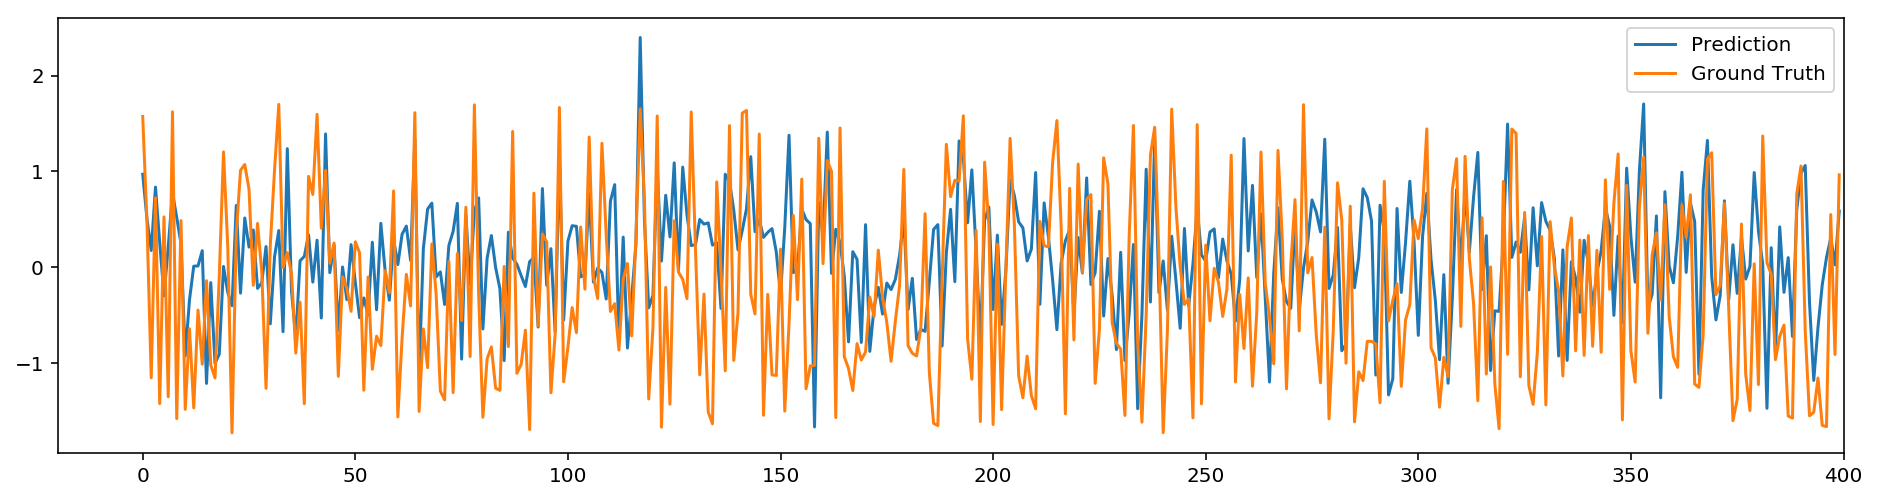

In [17]:
fig, ax = plt.subplots(figsize=(16,4))

# mean, std = scales_target
# predictions = network.run(train_features[0:400])*std + mean
predictions = network.run(train_features[0:400]).T
ax.plot(predictions[:,0], label='Prediction')

# ax.plot((train_targets[0:2000]*std + mean).values, label='Data')
ax.plot(train_targets[0:400].values, label='Ground Truth')
ax.set_xlim(right=len(predictions))
ax.legend()

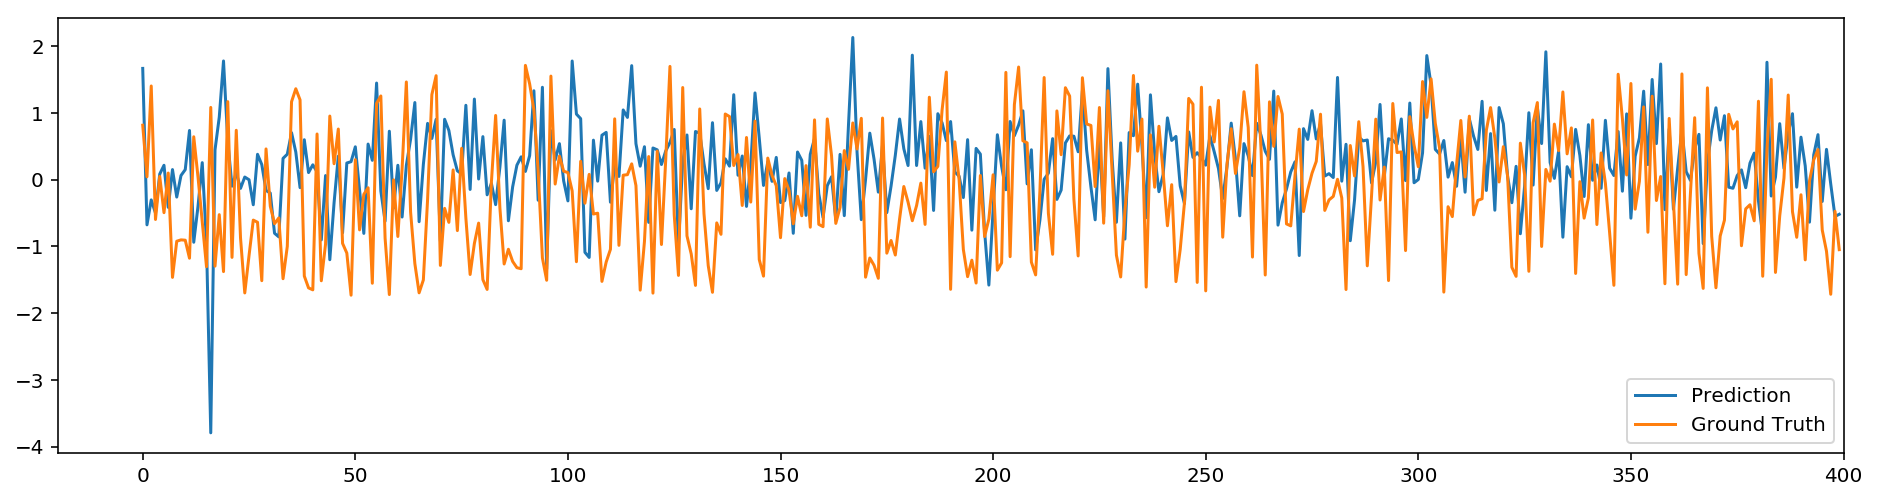

In [18]:
fig, ax = plt.subplots(figsize=(16,4))

# mean, std = scales_target
# predictions = network.run(val_features)*std + mean
predictions = network.run(val_features).T
ax.plot(predictions[:,0], label='Prediction')
# ax.plot((val_targets*std + mean).values, label='Data')

ax.plot(val_targets.values, label='Ground Truth')
ax.set_xlim(right=len(predictions))
ax.legend()

## Predictions on Testing data

Here, use the test data to view how well the network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

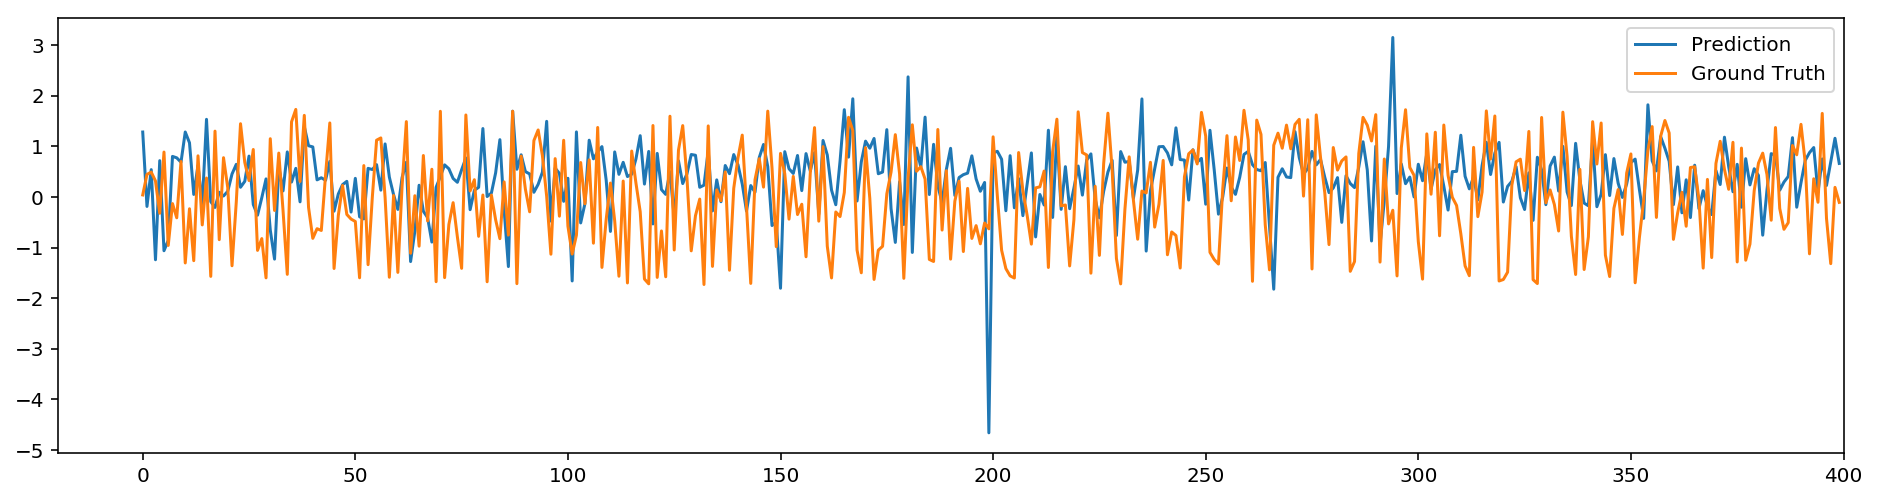

In [19]:
fig, ax = plt.subplots(figsize=(16,4))

# mean, std = scales_target
# predictions = network.run(test_features)*std + mean
predictions = network.run(test_features).T
ax.plot(predictions[:,0], label='Prediction')
# ax.plot((test_targets*std + mean).values, label='Data')

ax.plot(test_targets.values, label='Ground Truth')
ax.set_xlim(right=len(predictions))
ax.legend()

## Unit tests

Run these unit tests to check the correctness of the network implementation.

In [15]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.sigmoid(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.EF..
ERROR: test_data_loaded (__main__.TestMethods)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-15-1b584817c956>", line 21, in test_data_loaded
    self.assertTrue(isinstance(rides, pd.DataFrame))
NameError: name 'rides' is not defined

FAIL: test_data_path (__main__.TestMethods)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-15-1b584817c956>", line 17, in test_data_path
    self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
AssertionError: False is not true

----------------------------------------------------------------------
Ran 5 tests in 0.010s

FAILED (failures=1, errors=1)


<unittest.runner.TextTestResult run=5 errors=1 failures=1>